In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import torch

from model import *

In [3]:
sns.set(style='darkgrid')
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Data Generation

In [4]:
num_mentors = 200
num_mentees = 500
num_matches = 450
num_features = 20
num_truth = 100

# Generate underlying features
mentee_truth = np.random.rand(num_mentees, num_truth)
mentor_truth = np.random.rand(num_mentors, num_truth)

# Transform into survey features
feature_transform = np.random.rand(num_truth, num_features)
mentee_features = mentee_truth @ feature_transform
mentor_features = mentor_truth @ feature_transform

# Generate matches and match quality
matches_mentees = np.random.choice(range(num_mentees), num_matches, replace=False)
matches_mentors = np.random.choice(range(num_mentors), num_matches, replace=True)
matches = np.stack((matches_mentees, matches_mentors), axis=1)
matches_outcome = np.array([
    np.sum(mentee_truth[id1] * mentor_truth[id2])
    / (np.linalg.norm(mentee_truth[id1]) * np.linalg.norm(mentor_truth[id2]))
    for id1, id2 in matches])

# Cast to type
matches = torch.Tensor(matches).int()
matches_outcome = torch.Tensor(matches_outcome).float()

## Visualization

In [5]:
# Generate graph
G = nx.Graph()
G_edges = np.array(matches)
G_edges[:, 1] = G_edges[:, 1] + num_mentees

# Plot graph
G.add_nodes_from(range(num_mentees + num_mentors))
G_node_colors = []
for node in G:
    if node < num_mentees:
        G_node_colors.append(color[0])
    else:
        G_node_colors.append(color[1])
G.add_edges_from(G_edges)

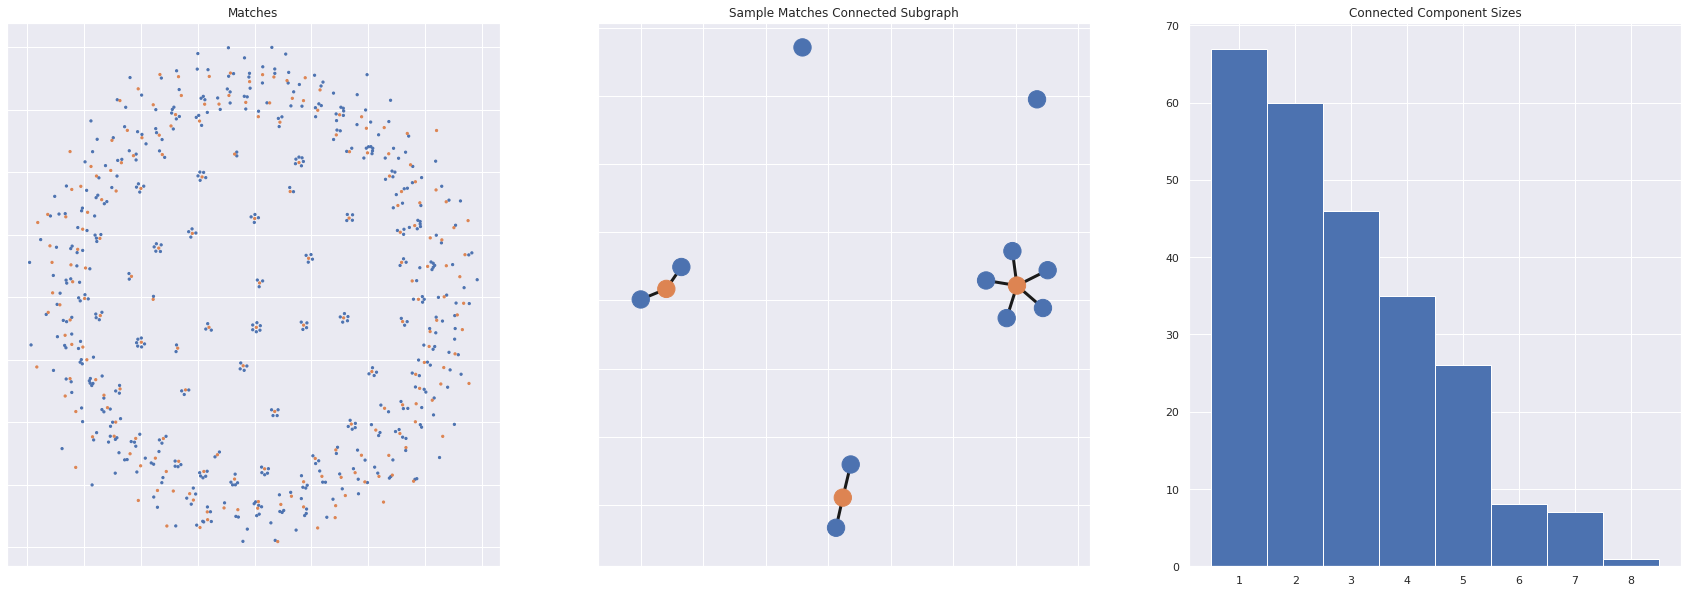

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(30,10))

# Plot graph
plt.sca(axs[0])
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=5, node_color=G_node_colors)
# nx.draw_networkx_edges(lcs, pos_lcs, width=1) 
plt.title('Matches')

# Plot largest connected subgraphs
plt.sca(axs[1])
lcs = G.subgraph([n for c in np.array(sorted(nx.connected_components(G), key=len, reverse=True))[np.random.choice(nx.number_connected_components(G), 5)] for n in c])
lcs_idx = [n for n in lcs]
lcs_colors = np.array(G_node_colors)[lcs_idx]
pos_lcs = nx.spring_layout(lcs)
nx.draw_networkx_nodes(lcs, pos_lcs, node_size=300, node_color=lcs_colors)
nx.draw_networkx_edges(lcs, pos_lcs, width=3) 
plt.title('Sample Matches Connected Subgraph')

# Plot connected components
plt.sca(axs[2])
component_lengths = {}
for component in nx.connected_components(G):
    if len(component) not in component_lengths:
        component_lengths[len(component)] = 0
    component_lengths[len(component)] += 1
component_lengths = list(np.transpose(np.array(sorted(component_lengths.items()))))
plt.bar(*component_lengths, width=1)
plt.title('Connected Component Sizes')

plt.show()

# Standalone Models

## Generate Embedding Space

In [7]:
dim_embedding = 10

In [8]:
epochs = 501
batches = 20
batch_size = int(len(matches)/batches)

In [9]:
gen_model = EmbeddingGenerationModel(num_mentees, num_mentors, dim=dim_embedding)
gen_optimizer = torch.optim.AdamW(gen_model.parameters())
gen_criterion = nn.MSELoss()

In [10]:
gen_model.train()
for epoch in range(epochs):
    for _ in range(batches):
        gen_optimizer.zero_grad()
        idx = np.random.choice(range(len(matches)), batch_size, replace=False)
        input_data = torch.t(matches[idx])
        logits = gen_model(*input_data)
        loss = gen_criterion(logits, matches_outcome[idx])
        loss.backward()
        gen_optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} \tLoss: {float(loss.detach())}')
gen_model.eval();

Epoch: 0 	Loss: 0.8870083093643188
Epoch: 100 	Loss: 0.07593567669391632
Epoch: 200 	Loss: 0.018110204488039017
Epoch: 300 	Loss: 0.0002664906205609441
Epoch: 400 	Loss: 2.0916655785185867e-07
Epoch: 500 	Loss: 6.0695368730989685e-09


## Infer Applicant Embeddings

In [11]:
epochs = 501
batches = 20
batch_size = int(num_mentees/batches)

In [12]:
inf_model = EmbeddingInferenceModel(num_features, dim=dim_embedding)
inf_optimizer = torch.optim.AdamW(inf_model.parameters())
inf_criterion = nn.MSELoss()

In [13]:
inf_model.train()
for epoch in range(epochs):
    for _ in range(batches):
        inf_optimizer.zero_grad()
        idx = np.random.choice(range(num_mentees), batch_size, replace=False)
        input_data = torch.Tensor(mentee_features[idx])
        logits = inf_model(input_data)
        true = gen_model.mentees(torch.Tensor(idx).int()).detach()
        loss = inf_criterion(logits, true)
        loss.backward()
        inf_optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} \tLoss: {float(loss.detach())}')
inf_model.eval();

Epoch: 0 	Loss: 1.6787430047988892
Epoch: 100 	Loss: 0.5122298002243042
Epoch: 200 	Loss: 0.4190410077571869
Epoch: 300 	Loss: 0.5106467604637146
Epoch: 400 	Loss: 0.36721351742744446
Epoch: 500 	Loss: 0.3540554642677307


## Visualization

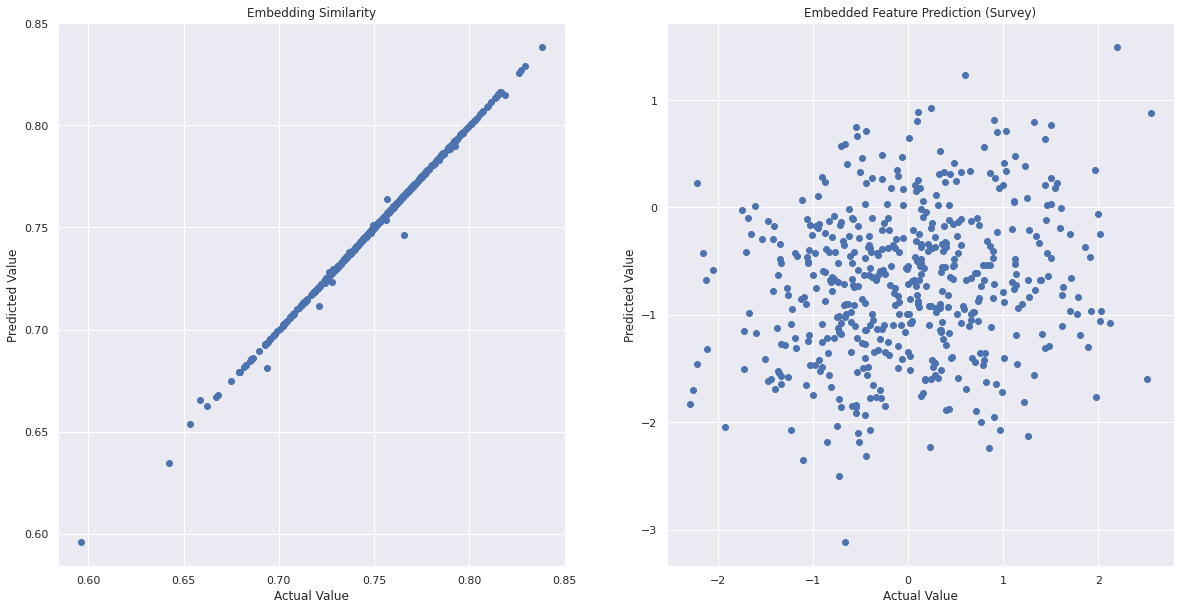

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))

# Plot embedding accuracy
plt.sca(axs[0])
input_data = torch.t(matches)
predicted = gen_model(*input_data).detach().cpu().numpy()
actual = matches_outcome

plt.scatter(actual, predicted)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Embedding Similarity')

# Plot survey features
plt.sca(axs[1])
feature = 0
input_data = torch.Tensor(mentee_features)
predicted = inf_model(input_data).detach().cpu().numpy()
actual = gen_model.mentees(torch.Tensor(range(num_mentees)).int()).detach().cpu().numpy()
predicted, actual = predicted[:, feature], actual[:, feature]

plt.scatter(actual, predicted)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Embedded Feature Prediction (Survey)');

# Adversarial Model

In [15]:
epochs = 501
batches = 20
batch_size = int(len(matches)/batches)

In [16]:
gen_model = EmbeddingGenerationModel(num_mentees, num_mentors, dim=dim_embedding)
gen_optimizer = torch.optim.AdamW(gen_model.parameters())
gen_criterion = nn.MSELoss()

In [17]:
inf_model = EmbeddingInferenceModel(num_features, dim=dim_embedding)
inf_optimizer = torch.optim.AdamW(inf_model.parameters())
inf_criterion = nn.MSELoss()

In [18]:
adv_criterion = nn.MSELoss()

In [19]:
gen_model.train()
inf_model.train()
for epoch in range(epochs):
    for _ in range(batches):
        loss = 0
        
        # Train embeddings
        gen_optimizer.zero_grad()
        gen_idx = np.random.choice(range(len(matches)), batch_size, replace=False)
        gen_input_data = torch.t(matches[gen_idx])
        gen_logits = gen_model(*gen_input_data)
        gen_loss = gen_criterion(gen_logits, matches_outcome[gen_idx])
        gen_loss.backward()
        gen_optimizer.step()
        loss += gen_loss.detach()
        
        # Train survey features
        inf_optimizer.zero_grad()
        inf_idx = np.unique(matches[gen_idx, 0])
        inf_input_data = torch.Tensor(mentee_features[inf_idx])
        inf_logits = inf_model(inf_input_data)
        inf_true = gen_model.mentees(torch.Tensor(inf_idx).int()).detach()
        inf_loss = inf_criterion(inf_logits, inf_true)
        inf_loss.backward(retain_graph=True)
        inf_optimizer.step()
        loss += inf_loss.detach()
        
        # Adversarial loss
        gen_optimizer.zero_grad()
        inf_optimizer.zero_grad()
        adv_loss = adv_criterion(inf_model(inf_input_data), gen_model.mentees(torch.Tensor(inf_idx).int()))
        adv_loss.backward()
        gen_optimizer.step()
        inf_optimizer.step()
        
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} \tLoss: {float(loss)}')
gen_model.eval();

Epoch: 0 	Loss: 2.551147699356079
Epoch: 100 	Loss: 0.3963475227355957
Epoch: 200 	Loss: 0.06316380202770233
Epoch: 300 	Loss: 0.021371906623244286
Epoch: 400 	Loss: 0.0030194378923624754
Epoch: 500 	Loss: 0.0012599572073668242


## Visualization

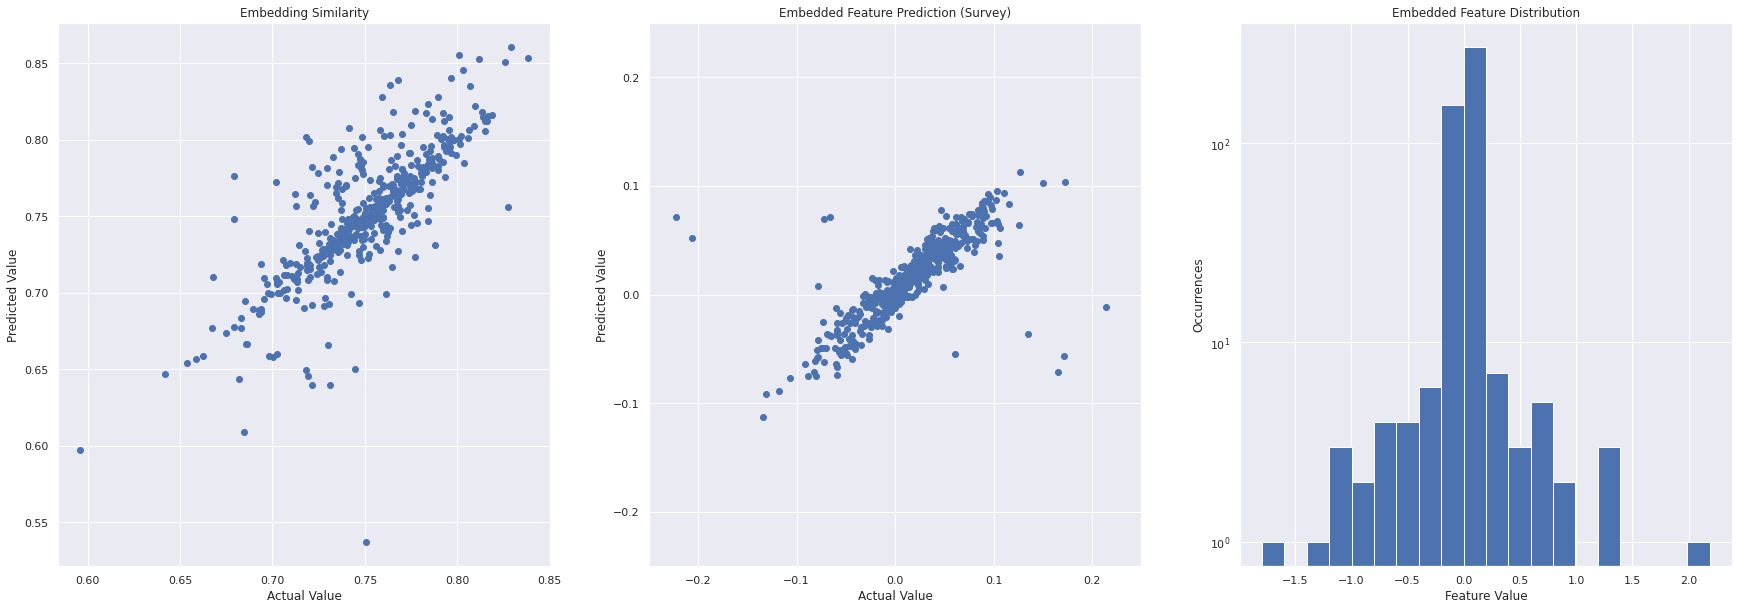

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(30,10))

# Plot embedding accuracy
plt.sca(axs[0])
input_data = torch.t(matches)
predicted = gen_model(*input_data).detach().cpu().numpy()
actual = matches_outcome

plt.scatter(actual, predicted)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Embedding Similarity')

# Plot survey features
plt.sca(axs[1])
feature = 0
input_data = torch.Tensor(mentee_features)
predicted = inf_model(input_data).detach().cpu().numpy()
actual = gen_model.mentees(torch.Tensor(range(num_mentees)).int()).detach().cpu().numpy()
predicted, actual = predicted[:, feature], actual[:, feature]

plt.scatter(actual, predicted)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Embedded Feature Prediction (Survey)')
plt.xlim(-.25, .25)
plt.ylim(-.25, .25)

# Plot histogram of survey values
plt.sca(axs[2])
plt.hist(actual, bins=20)
plt.xlabel('Feature Value')
plt.ylabel('Occurrences')
plt.title('Embedded Feature Distribution')
plt.gca().set_yscale('log');